In [1]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split as splitter 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error as mse 
import sklearn.metrics as metrics
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion 

features = np.genfromtxt("./Aggregated_Data.csv", delimiter=",", usecols=(1, 3, 4, 5))
target = np.genfromtxt("./Aggregated_Data.csv", delimiter=",", usecols=8)
X = np.delete(features,[0], axis=0)
Y = np.delete(target, [0], axis=0)

# split data into train/test sets 
x_train, x_test, y_train, y_test = splitter(X, Y, test_size=0.25, random_state=0)

# scale the data, which is 'highly recommended' for MLP
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# init and fit the model
network = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3,), random_state=0, shuffle=True)
network.fit(x_train, y_train)

# score on test data 
score = network.score(x_test, y_test)
print(score)

#looked at this: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
#and this: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

0.952


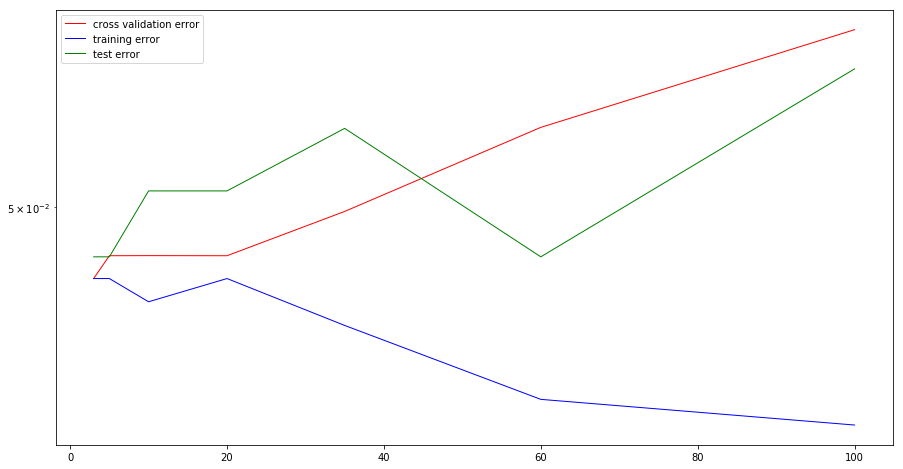

In [2]:
x_train, x_test, y_train, y_test = splitter(X, Y, test_size=0.25, random_state=0) 

def cv(neuron_count, folds): 
    kf = KFold(n_splits=folds, shuffle=False)
    err = []

    for train_idx, test_idx in kf.split(x_train, y_train): 
        xtr_cv, xte_cv = x_train[train_idx], x_train[test_idx]
        ytr_cv, yte_cv = y_train[train_idx], y_train[test_idx]
        
        s = StandardScaler().fit(xtr_cv)
        xtr_cv = s.transform(xtr_cv)
        xte_cv = s.transform(xte_cv)
        
        classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(neuron_count,), random_state=0, shuffle=True)
        classifier.fit(xtr_cv, ytr_cv)
        yte_pred = classifier.predict(xte_cv)
        err.append(mse(yte_pred, yte_cv))
    
    return np.mean(err)

neuron_counts = [3, 5, 10, 20, 35, 60, 100]
cv_err = []
for num in neuron_counts: 
    cv_err.append(cv(num, 5))
    
# rescale data after CV
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
    

# calculate train/test error for various neuron count
train_err = []
test_err = []
for num in neuron_counts: 
    n = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(num,), random_state=0, shuffle=True)
    n.fit(x_train, y_train)

    tr_pred = n.predict(x_train)
    te_pred = n.predict(x_test)
    
    train_err.append(mse(tr_pred, y_train))
    test_err.append(mse(te_pred, y_test))
    
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.semilogy(neuron_counts, cv_err, 'r', neuron_counts, train_err, 'b', neuron_counts, test_err, 'g', linewidth=1)
plt.legend(['cross validation error', 'training error', 'test error'], loc='upper left')


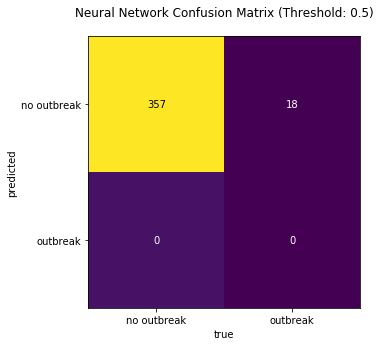

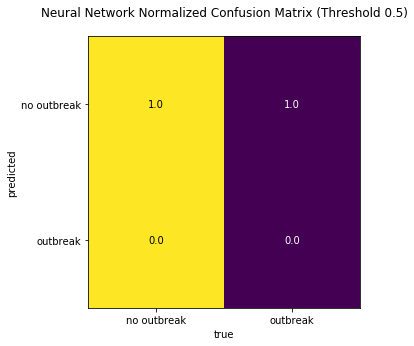

TypeError: plot_confusion_matrix() missing 3 required positional arguments: 'matrix', 'title', and 'color'

In [3]:
def plot_confusion_matrix(matrix, title, color):
    
    plt.rcParams['figure.figsize'] = (5.0, 5.0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    plt.title(title)
    #fig.colorbar(cax)
    
    ax.xaxis.tick_bottom()
    labels = ['no outbreak', 'outbreak']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('true')
    plt.ylabel('predicted')

    plt.text(0, 0, str(matrix[0][0]), horizontalalignment="center", verticalalignment="center" ,color="black")
    plt.text(0, 1, str(matrix[0][1]), horizontalalignment="center", verticalalignment="center" ,color=color)
    plt.text(1, 0, str(matrix[1][0]), horizontalalignment="center", verticalalignment="center" ,color="white")
    plt.text(1, 1, str(matrix[1][1]), horizontalalignment="center", verticalalignment="center" ,color="white")
    plt.show()
    
    #print('true negatives: {}'.format(matrix[0][0]))
    #print('false positive: {}'.format(matrix[0][1]))
    #print('false negatives: {}'.format(matrix[1][0]))
    #print('true positive: {}'.format(matrix[1][1]))

prediction = network.predict(x_test)
matrix = confusion(y_test, prediction, [0,1])
norm = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(matrix, "Neural Network Confusion Matrix (Threshold: 0.5)", "white")
plot_confusion_matrix(norm, "Neural Network Normalized Confusion Matrix (Threshold 0.5)", "black")

#used this:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#and this:https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785

In [ ]:
def plot_roc():
    probs = network.predict_proba(x_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, probs)
    auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, c='r', label='AUC: {}'.format(auc))
    plt.ylabel('true positive rate')
    plt.xlabel('false positive rate')
    
    plt.legend()
    plt.show()
    
plot_roc()

#looked at this for roc:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html